# Zastosowanie regresji logistycznej w problemie niezbalansowanych danych 

Niniejsza analiza dotyczy problemu wytypowania pracowników, którzy potencjalnie mogą planować opuścić swój zakład pracy. Lista potencjalnych osób, które mogą wkrótce zacząć szukać nowej pracy, może okazać się bardzo przydatnym narzędziem dla działu HR. Posiadając wiedzę na ten temat można próbować zapobiegać ewentualnym wypowiedzeniom umowy przez pracowników, zanim jeszcze zostaną one złożone. Taka sytuacja w szczególności ma miejsce, gdy na rynku pracy jest mało wysoko wyspecjalizowanych pracowników przy stosunkowo dużej liczbie miejsc pracy. Wtedy zaproponowanie podwyżki i benefitów lub renegocjacja innych aspektów umowy może okazać się dużo mniejszym kosztem niż szukanie i szkolenie nowego pracownika.
Wiedza o potencjalnym odejściu danej osoby może również pomóc pracodawcy w zauważeniu potencjalnych braków w ciągłości całego procesu pracy. Wczesne przygotowanie innych pracowników na wypadek potencjalnego odejścia "osoby niezastąpionej" z pewnością pozwoli zabezpieczyć los firmy. Należy również pamiętać, że pracownicy nie zmieniają pracy tylko w formie awansu. Pracownicy wytypowani przez to narzędzie mogą być osobami, które są bliskie lub już wypalone zawodowo. Wczesna interwencja działu HR i przełożonego mogą pomóc takiemu pracownikowi ponownie odnaleźć sens i motywację do dalszej pracy. 

Problem zostanie rozwiązany przy użyciu danych o pracownikach pewnej firmy.  Na dane składają się następujące zmienne: 

1. S - określa poziom ogólnej satysfakcji (Satisfaction) z pracy w skali od 0 do 1. Wyższa wartość ułamka oznacza wyższą satysfakcję pracownika. 
2. LPE - określa ocenę ostatniego wykonanego projektu (Last Project Evaluation) pracownika w skali od 0 do 1. Wyższa wartość ułamka oznacza wyższą satysfakcję pracownika. Ocena jest wystawiana przez klienta, dla którego projekt został wykonany. 
3. NP - określa liczbę projektów (Number of Projects), w których pracownik brał udział w ostatnich 12 miesiącach. 
4. ANH - określa średnią liczbę godzin przepracowanych (Average Number of Hours) miesięcznie w horyzoncie czasowym ostatnich 12 miesięcy. 
5. TIC - określa staż pracy w firmie (Time In Company) liczony w latach. 
6. Newborn - określa, czy w ostatnich 12 miesięcy pracownikowi urodziło się dziecko. Zmienna przyjmuje 2 wartości: 1 - pracownikowi urodziło się dziecko w ostatnich 12 miesiącach, 0 - pracownikowi nie urodziło się dziecko w ostatnich 12 miesiącach. 
7. Left - określa, czy pracownik opuścił już firmę. Zmienna przyjmuje 2 wartości: 1 - pracownikowi opuścił już firmę, 0 - pracownik wciąż jest zatrudniony przez firmę. Jest to zmienna zależna (celu). 

Dane składają się zatem z 3 części: pierwszą jest zdanie pracownika o firmie, drugą niezależna od firmy ocena ostatniego projektu, a trzecią są dane odnośnie ogólnej sytuacji pracownika. Takie podejście pozwoli na małoinwazyjne zebranie informacji od osób badanych. Należy tutaj pamiętać, że osoby planujące zmianę pracy mogą nie chcieć, by inni pracownicy (w szczególności przełożony) wiedzieli o ich planach.

Przedstawiony powyżej problem rozwiązany zostanie przy pomocy regresji logistycznej. Zbudowany zostanie klasyfikator, który będzie próbował oszacować prawdopodobieństwo odejścia danego pracownika na podstawie jego wektora obserwacji przedstawionych zmiennych niezależnych.

In [1]:
library(data.table)
library(Information)
library(ggplot2)
library(corrplot)
library(gam)
library(ROCR)
library(sqldf)

Warning message:
"package 'data.table' was built under R version 3.6.3"Warning message:
"package 'Information' was built under R version 3.6.3"corrplot 0.90 loaded
Warning message:
"package 'gam' was built under R version 3.6.3"Loading required package: splines
Loading required package: foreach
Warning message:
"package 'foreach' was built under R version 3.6.3"Loaded gam 1.16.1

Warning message:
"package 'ROCR' was built under R version 3.6.3"Warning message:
"package 'sqldf' was built under R version 3.6.3"Loading required package: gsubfn
Warning message:
"package 'gsubfn' was built under R version 3.6.3"Loading required package: proto
Warning message:
"package 'proto' was built under R version 3.6.3"Loading required package: RSQLite
Warning message:
"package 'RSQLite' was built under R version 3.6.3"

In [2]:
dane=read.csv('hr.csv')

## Przygotowanie danych

Prace na danych zaczniemy od podziału zbioru danych na zbiór treningowy i testowy. Zbiór treningowy to 70% losowo wybranych wszystkich obserwacji, pozostałe trafią do zbioru testowego. 

In [3]:
dane=data.table(dane)
dane[,Newborn := as.factor(Newborn)]

set.seed(4321)
dane[,train:=rbinom(dim(dane)[1],1,0.7)]
dane_trn=dane[train==1]
dane_tst=dane[train==0]

dane_trn=dane_trn[,train:=NULL]
dane_tst=dane_tst[,train:=NULL]
dane_trn2=copy(dane_trn)
dane_tst2=copy(dane_tst)

In [4]:
print('dane pełne')
summary(dane)
print('dane treningowe')
summary(dane_trn)
print('dane testowe')
summary(dane_tst)

[1] "dane pełne"


       S               LPE               NP             ANH       
 Min.   :0.0900   Min.   :0.3600   Min.   :2.000   Min.   : 96.0  
 1st Qu.:0.4800   1st Qu.:0.5700   1st Qu.:3.000   1st Qu.:157.0  
 Median :0.6600   Median :0.7200   Median :4.000   Median :199.5  
 Mean   :0.6295   Mean   :0.7166   Mean   :3.802   Mean   :200.4  
 3rd Qu.:0.8200   3rd Qu.:0.8600   3rd Qu.:5.000   3rd Qu.:243.0  
 Max.   :1.0000   Max.   :1.0000   Max.   :7.000   Max.   :310.0  
      TIC        Newborn        left            train       
 Min.   :2.000   0:10150   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:2.000   1: 1850   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :3.000             Median :0.0000   Median :1.0000  
 Mean   :3.229             Mean   :0.1667   Mean   :0.6991  
 3rd Qu.:4.000             3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :6.000             Max.   :1.0000   Max.   :1.0000  

[1] "dane treningowe"


       S               LPE               NP             ANH       
 Min.   :0.0900   Min.   :0.3600   Min.   :2.000   Min.   : 96.0  
 1st Qu.:0.4900   1st Qu.:0.5700   1st Qu.:3.000   1st Qu.:158.0  
 Median :0.6600   Median :0.7200   Median :4.000   Median :200.0  
 Mean   :0.6319   Mean   :0.7153   Mean   :3.795   Mean   :200.6  
 3rd Qu.:0.8300   3rd Qu.:0.8600   3rd Qu.:5.000   3rd Qu.:243.0  
 Max.   :1.0000   Max.   :1.0000   Max.   :7.000   Max.   :310.0  
      TIC       Newborn       left       
 Min.   :2.00   0:7071   Min.   :0.0000  
 1st Qu.:2.00   1:1318   1st Qu.:0.0000  
 Median :3.00            Median :0.0000  
 Mean   :3.22            Mean   :0.1622  
 3rd Qu.:4.00            3rd Qu.:0.0000  
 Max.   :6.00            Max.   :1.0000  

[1] "dane testowe"


       S               LPE               NP             ANH       
 Min.   :0.0900   Min.   :0.3600   Min.   :2.000   Min.   : 96.0  
 1st Qu.:0.4600   1st Qu.:0.5700   1st Qu.:3.000   1st Qu.:157.0  
 Median :0.6600   Median :0.7300   Median :4.000   Median :199.0  
 Mean   :0.6237   Mean   :0.7194   Mean   :3.819   Mean   :200.1  
 3rd Qu.:0.8200   3rd Qu.:0.8700   3rd Qu.:5.000   3rd Qu.:243.0  
 Max.   :1.0000   Max.   :1.0000   Max.   :7.000   Max.   :310.0  
      TIC        Newborn       left      
 Min.   :2.000   0:3079   Min.   :0.000  
 1st Qu.:3.000   1: 532   1st Qu.:0.000  
 Median :3.000            Median :0.000  
 Mean   :3.248            Mean   :0.177  
 3rd Qu.:4.000            3rd Qu.:0.000  
 Max.   :6.000            Max.   :1.000  

Powyższe porównanie trzech zbiorów pokazuje kilka interesujących informacji. Zbiór danych nie zawiera w sobie żadnych brakujących obserwacji. Nie wygląda na to, że w danych są jakieś błędy natury logicznej - zakresy poszczególnych zmiennych wydają się możliwe do osiągnięcia. Dane są wyrazie niezbalansowane - tylko 17% wszystkich obserwacji to osoby, które zrezygnowały z pracy. Wszystkie trzy zbiory są do siebie podobne pod względem statystyk opisowych.

By uniknąć przecieku informacji, od teraz rozpatrywany będzie tylko zbiór treningowy. Wizualizacja pomoże lepiej zrozumieć dane.

## Wizualizacja danych

In [5]:
licznosc_grup_S=data.table(przedzial = seq(0.1,1,0.1),wszyscy = 1:10, zrezygnowali = 1:10)
for (i in 1:10)
{
    licznosc_grup_S[i,2] = dane_trn[0.1*(i-1)<S & S<=0.1*i,.N]
    licznosc_grup_S[i,3] = dane_trn[0.1*(i-1)<S & S<=0.1*i & left==1,.N]

}
licznosc_grup_S[,zostali:=wszyscy-zrezygnowali]
licznosc_grup_S[,procent:=round(zrezygnowali/wszyscy,2)*100]
licznosc_grup_S[,przedzial:=as.factor(przedzial)]


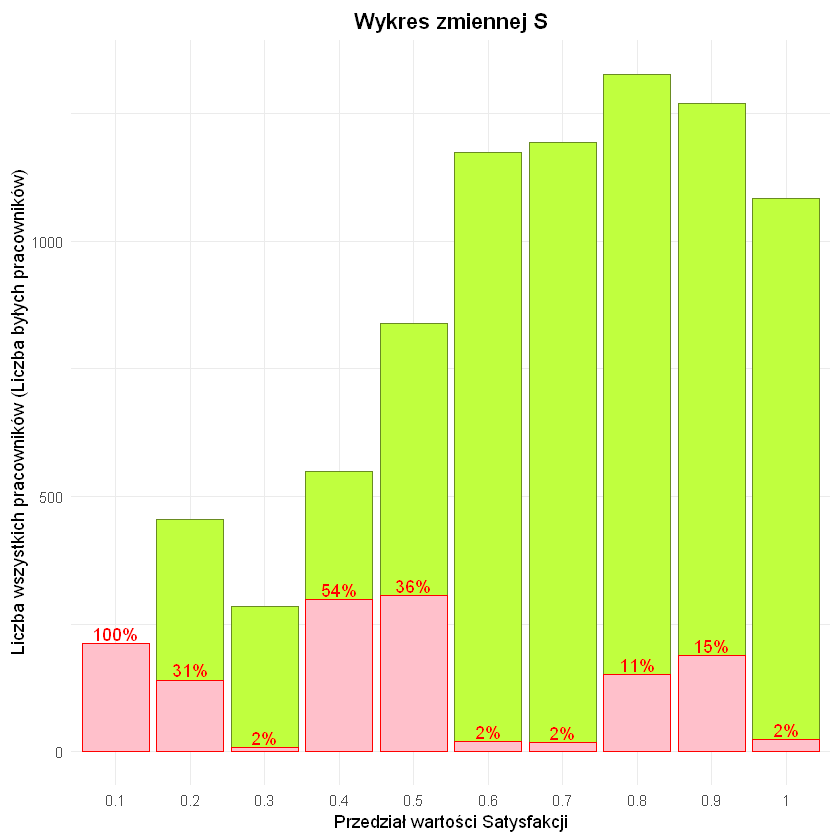

In [7]:
ggplot(data=licznosc_grup_S, aes(x=przedzial,wszyscy, zrezygnowali)) +
geom_bar(aes(y=wszyscy),stat="identity",color="olivedrab4",fill="olivedrab1",position = "dodge") +
geom_bar(aes(y=zrezygnowali),stat="identity",color="red",fill="pink",position = "dodge") +
labs(x = "Przedział wartości Satysfakcji", y = "Liczba wszystkich pracowników (Liczba byłych pracowników)") +
ggtitle("Wykres zmiennej S") +
theme_minimal() +
theme(plot.title=element_text( hjust=0.5, vjust=0.5, face='bold')) +
annotate("text", x=licznosc_grup_S[1,1]$przedzial, y=licznosc_grup_S[1,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[1,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[2,1]$przedzial, y=licznosc_grup_S[2,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[2,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[3,1]$przedzial, y=licznosc_grup_S[3,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[3,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[4,1]$przedzial, y=licznosc_grup_S[4,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[4,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[5,1]$przedzial, y=licznosc_grup_S[5,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[5,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[6,1]$przedzial, y=licznosc_grup_S[6,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[6,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[7,1]$przedzial, y=licznosc_grup_S[7,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[7,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[8,1]$przedzial, y=licznosc_grup_S[8,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[8,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[9,1]$przedzial, y=licznosc_grup_S[9,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[9,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_S[10,1]$przedzial, y=licznosc_grup_S[10,3]$zrezygnowali+20, label= paste0(licznosc_grup_S[10,5]$procent,"%",collapse=''), color='red')

In [6]:
licznosc_grup_S

przedzial,wszyscy,zrezygnowali,zostali,procent
0.1,211,211,0,100
0.2,455,140,315,31
0.3,284,7,277,2
0.4,549,298,251,54
0.5,840,306,534,36
0.6,1174,19,1155,2
0.7,1194,18,1176,2
0.8,1328,151,1177,11
0.9,1270,188,1082,15
1,1084,23,1061,2


Wykres powyżej przedstawia zmienną S (Satysfakcja) podzieloną na 10 grup, są to przedziały wartości: (0;0.1], (0.1;0.2], ..., (0.8;0.9], (0.9;1]. Na wykresie dany przedział jest opisany na osi X jego górnym (domkniętym) krańcem. Zielone słupki przedstawiają liczność wszystkich pracowników zbioru treningowego. Czerwone słupki to pracownicy, którzy zrezygnowali już z pracy. Liczby wyrażone w procentach nad czerwonymi słupkami to ilorazy liczby byłych pracowników i liczby wszystkich pracowników w danej grupie. 

Porównując ze sobą dwie połowy wykresu - od 0 do 0.5 i od 0.6 do 1 - można dostrzec, że większość pracowników ze zbioru treningowego oceniła swoją satysfakcję z pracy na przynajmniej 50%. Pierwsza połowa wykresu wykazuje zdecydowanie wyższe procentowe wartości liczby byłych pracowników. Wszystkie osoby z grupy, gdzie oceniano swoją satysfakcję z pracy na mniej niż 0.1, już nie pracują w tej firmie. Stosunkowo wysokie czerwone słupki dla wartości S z przedziałów (0.7;0.8] i (0.8;0.9] można tłumaczyć tym, że osoby rezygnujące z pracy w tych przedziałach dostały lepszą ofertę w innym miejscu. Innym wytłumaczeniem wysokości tych słupków może być obecność osób, które starają się ukryć swoje niezadowolenie przed przełożonymi - są to osoby jednocześnie pracujące i aktywnie szukające innego miejsca pracy. 

In [8]:
licznosc_grup_LPE=data.table(przedzial = seq(0.4,1,0.1),wszyscy = 1:7, zrezygnowali = 1:7)
for (i in 1:7)
{
    licznosc_grup_LPE[i,2] = dane_trn[0.3+0.1*(i-1)<LPE & LPE<=0.3+0.1*i,.N]
    licznosc_grup_LPE[i,3] = dane_trn[0.3+0.1*(i-1)<LPE & LPE<=0.3+0.1*i & left==1,.N]

}
licznosc_grup_LPE[,zostali:=wszyscy-zrezygnowali]
licznosc_grup_LPE[,procent:=round(zrezygnowali/wszyscy,2)*100]
licznosc_grup_LPE[,przedzial:=as.factor(przedzial)]


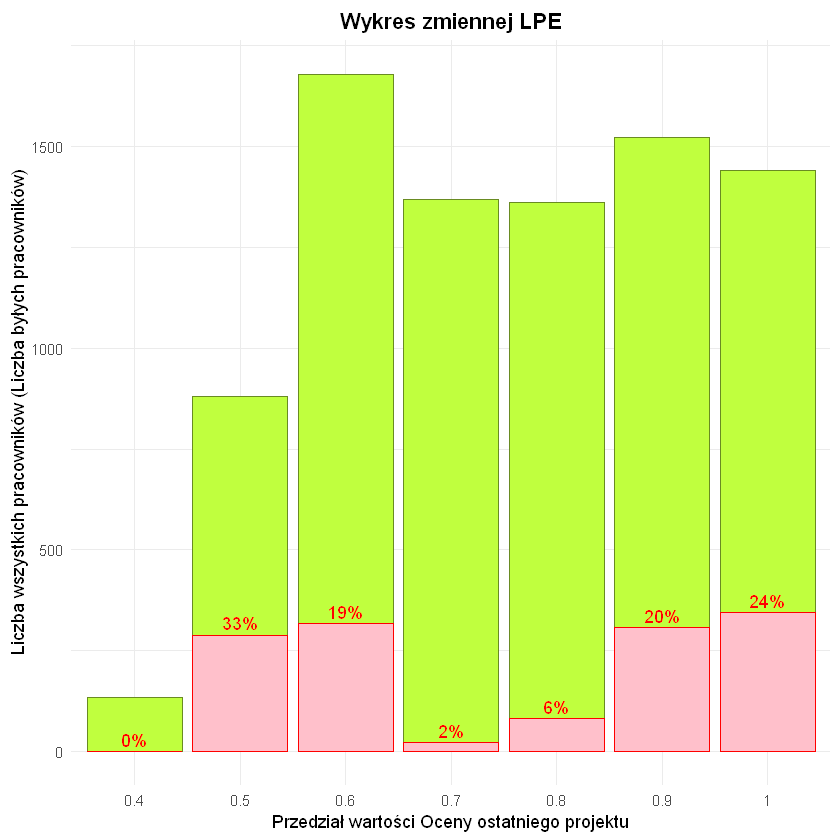

In [10]:
ggplot(data=licznosc_grup_LPE, aes(x=przedzial,wszyscy, zrezygnowali)) +
geom_bar(aes(y=wszyscy),stat="identity",color="olivedrab4",fill="olivedrab1",position = "dodge") +
geom_bar(aes(y=zrezygnowali),stat="identity",color="red",fill="pink",position = "dodge") +
labs(x = "Przedział wartości Oceny ostatniego projektu", y = "Liczba wszystkich pracowników (Liczba byłych pracowników)") +
ggtitle("Wykres zmiennej LPE") +
theme_minimal() +
theme(plot.title=element_text( hjust=0.5, vjust=0.5, face='bold')) +
annotate("text", x=licznosc_grup_LPE[1,1]$przedzial, y=licznosc_grup_LPE[1,3]$zrezygnowali+30, label= paste0(licznosc_grup_LPE[1,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_LPE[2,1]$przedzial, y=licznosc_grup_LPE[2,3]$zrezygnowali+30, label= paste0(licznosc_grup_LPE[2,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_LPE[3,1]$przedzial, y=licznosc_grup_LPE[3,3]$zrezygnowali+30, label= paste0(licznosc_grup_LPE[3,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_LPE[4,1]$przedzial, y=licznosc_grup_LPE[4,3]$zrezygnowali+30, label= paste0(licznosc_grup_LPE[4,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_LPE[5,1]$przedzial, y=licznosc_grup_LPE[5,3]$zrezygnowali+30, label= paste0(licznosc_grup_LPE[5,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_LPE[6,1]$przedzial, y=licznosc_grup_LPE[6,3]$zrezygnowali+30, label= paste0(licznosc_grup_LPE[6,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_LPE[7,1]$przedzial, y=licznosc_grup_LPE[7,3]$zrezygnowali+30, label= paste0(licznosc_grup_LPE[7,5]$procent,"%",collapse=''), color='red')

In [9]:
licznosc_grup_LPE

przedzial,wszyscy,zrezygnowali,zostali,procent
0.4,134,0,134,0
0.5,881,289,592,33
0.6,1680,317,1363,19
0.7,1368,23,1345,2
0.8,1362,81,1281,6
0.9,1522,307,1215,20
1,1442,344,1098,24


Powyższy wykres przedstawia zmienną LPE (Ocena ostatniego wykonanego projektu). Wykres należy czytać analogicznie do poprzedniego wykresu dla zmiennej S. Można z niego wywnioskować, że najgorzej oceniony projekt znajduje się w grupie 0.4 (co oznacza, że jego cena mieści się w przedziale (0.3;0.4]). Zaskakujące jest, że żaden pracownik, którego ostatni projekt został oceniony tak nisko, nie opuścił jeszcze firmy. Być może wśród tych pracowników są osoby, które te mają jeszcze niskie kompetencje i się uczą. Należy również dostrzec niewielką liczność tej grupy - 134 osoby. Pozostałe grupy są już lepiej reprezentowane. Tutaj procentowe wartości osób rezygnujących układają się w literę "U". Grupa o górnym krańcu 0.5 ma najwyższy procent rezygnowania z pracy. W dwóch kolejnych grupach jest tendencja spadkowa, a w trzech ostatnich tendencja zmienia się na rosnącą. Można się domyślać, że po lewej stronie wykresu są osoby czujące się źle z powodu niskiej oceny - być może zła ocena jest skutkiem nieporozumień i nieprzyjemnej atmosfery w pracy. Z prawej strony mamy projekty wykonane bardzo dobrze. Specjaliści, którzy wykonują swoje prace wzorowo, z pewnością są zauważani przez klientów i mogą od nich otrzymywać bezpośrednio oferty pracy, w których to pracownik dyktuje warunki potencjalnej współpracy. 

In [11]:
licznosc_grup_NP=data.table(przedzial = seq(2,7,1),wszyscy = 1:6, zrezygnowali = 1:6)
for (i in 1:6)
{
    licznosc_grup_NP[i,2] = dane_trn[NP==i+1,.N]
    licznosc_grup_NP[i,3] = dane_trn[NP==i+1 & left==1,.N]

}
licznosc_grup_NP[,zostali:=wszyscy-zrezygnowali]
licznosc_grup_NP[,procent:=round(zrezygnowali/wszyscy,2)*100]
licznosc_grup_NP[,przedzial:=as.factor(przedzial)]

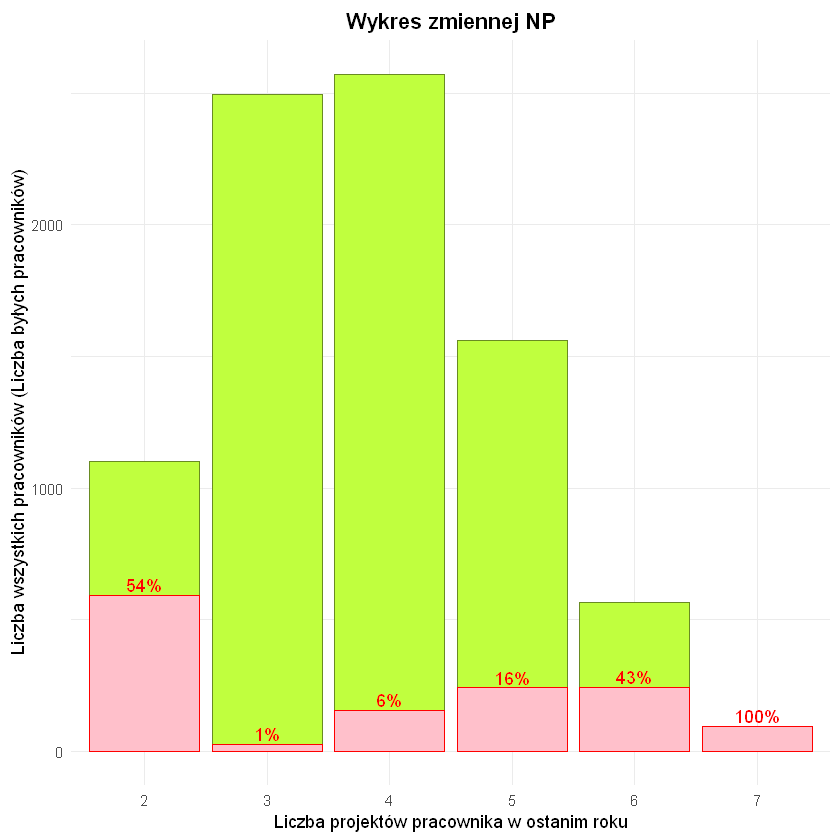

In [13]:
ggplot(data=licznosc_grup_NP, aes(x=przedzial,wszyscy, zrezygnowali)) +
geom_bar(aes(y=wszyscy),stat="identity",color="olivedrab4",fill="olivedrab1",position = "dodge") +
geom_bar(aes(y=zrezygnowali),stat="identity",color="red",fill="pink",position = "dodge") +
labs(x = "Liczba projektów pracownika w ostanim roku", y = "Liczba wszystkich pracowników (Liczba byłych pracowników)") +
ggtitle("Wykres zmiennej NP") +
theme_minimal() +
theme(plot.title=element_text( hjust=0.5, vjust=0.5, face='bold')) +
annotate("text", x=licznosc_grup_NP[1,1]$przedzial, y=licznosc_grup_NP[1,3]$zrezygnowali+40, label= paste0(licznosc_grup_NP[1,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_NP[2,1]$przedzial, y=licznosc_grup_NP[2,3]$zrezygnowali+40, label= paste0(licznosc_grup_NP[2,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_NP[3,1]$przedzial, y=licznosc_grup_NP[3,3]$zrezygnowali+40, label= paste0(licznosc_grup_NP[3,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_NP[4,1]$przedzial, y=licznosc_grup_NP[4,3]$zrezygnowali+40, label= paste0(licznosc_grup_NP[4,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_NP[5,1]$przedzial, y=licznosc_grup_NP[5,3]$zrezygnowali+40, label= paste0(licznosc_grup_NP[5,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_NP[6,1]$przedzial, y=licznosc_grup_NP[6,3]$zrezygnowali+40, label= paste0(licznosc_grup_NP[6,5]$procent,"%",collapse=''), color='red') 


In [12]:
licznosc_grup_NP

przedzial,wszyscy,zrezygnowali,zostali,procent
2,1102,594,508,54
3,2495,28,2467,1
4,2572,157,2415,6
5,1559,243,1316,16
6,566,244,322,43
7,95,95,0,100


Z powyższego wykresu dla zmiennej NP (Liczba Projektów) można odczytać, że najczęściej pracownik brał udział w 3 do 5 projektów. Przedziały te charakteryzują się również zdecydowanie niższym odsetkiem osób rezygnujących z pracy, porównując do pozostałych grup liczb projektów. Ponownie ukazuje się tutaj kształt litery "U", gdy spojrzy się na procentowy udział osób odchodzących z pracy w kolejnych grupach. Ciekawa wydaje się dość słabo reprezentowana grupa osób pracująca nad 7 projektami - wszyscy z 95 pracowników już nie pracuje w firmie. W grupach, gdzie pracowano nad 2 lub 6 projektami odsetek osób rezygnujących wciąż jest bardzo wysoki. 

Można zatem wywnioskować, że pracownicy najlepiej czują się w firmie, gdy pracują w ciągu roku nad 3-5 projektami. Można podejrzewać, że 2 projekty rocznie powodują, że pracownicy odczuwają znużenie brakiem nowości i ograniczonymi możliwościami rozwoju. Mała liczba projektów może również sygnalizować, że przynajmniej jednym z nich był jakiś problem, który niespodziewanie wydłużył czas jego realizacji. Firma, gdzie jest zła organizacja obowiązków, często cechuje się dużą rotacją pracowników. 

Z drugiej strony są pracownicy, którzy pracowali nad 6-7 projektami. Należy tu zaznaczyć, że wliczane są też projekty nieukończone. Duża liczba projektów może oznaczać, że część z nich upadła w trakcie realizacji. Taka sytuacja może wiązać się z poczuciem zlekceważenia, zmarnowanych sił, czasu oraz potencjału przez pracownika, zwłaszcza, gdy dany pracownik wykonywał swoje obowiązki należycie. Duża liczba projektów może również sygnalizować, że część z nich była trywialna i pracownik mógł czuć się przez to lekceważony. Jeszcze inną możliwością dużej liczby odejść jest możliwość pokazania się wielu różnym klientom. Duża liczba dobrze wykonanych projektów daje większy potencjał na to, że ktoś zauważy ciężko pracującą osobę i zaproponuje jej dużo lepsze warunki zatrudnienia. 

In [14]:
licznosc_grup_ANH=data.table(przedzial = seq(115,315,25),wszyscy = 1:9, zrezygnowali = 1:9)
for (i in 1:9)
{
    licznosc_grup_ANH[i,2] = dane_trn[95+25*(i-1)<ANH & ANH<=95+25*i,.N]
    licznosc_grup_ANH[i,3] = dane_trn[95+25*(i-1)<ANH & ANH<=95+25*i & left==1,.N]

}
licznosc_grup_ANH[,zostali:=wszyscy-zrezygnowali]
licznosc_grup_ANH[,procent:=round(zrezygnowali/wszyscy,2)*100]
licznosc_grup_ANH[,przedzial:=as.factor(przedzial)]


przedzial,wszyscy,zrezygnowali,zostali,procent
115,229,0,229,0
140,1072,321,751,30
165,1505,288,1217,19
190,1182,12,1170,1
215,1148,38,1110,3
240,1301,166,1135,13
265,1401,287,1114,20
290,468,166,302,35
315,83,83,0,100


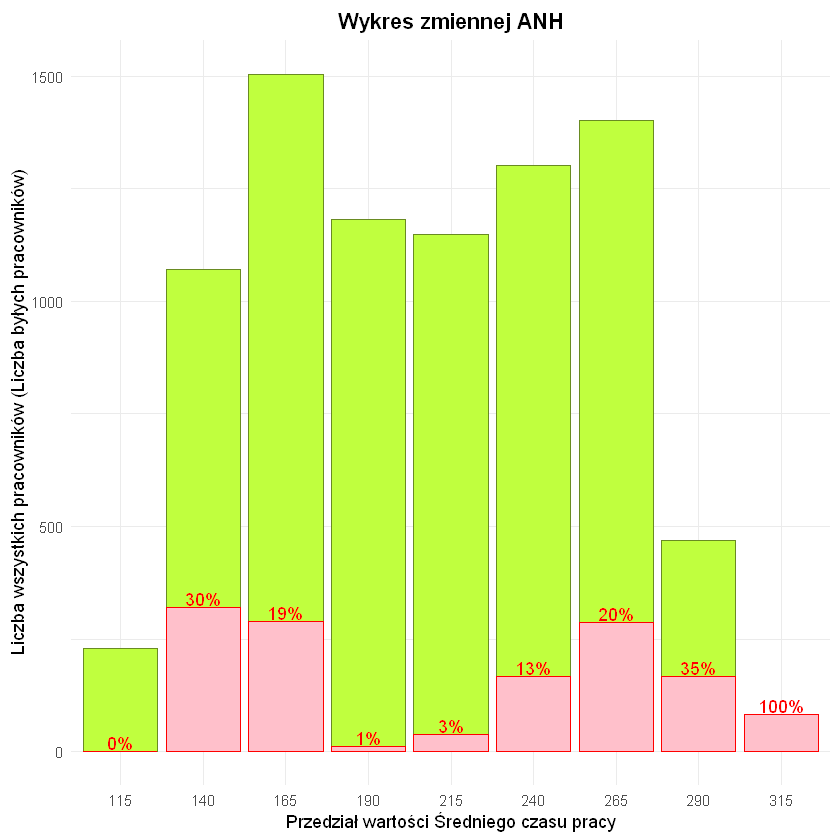

In [15]:
ggplot(data=licznosc_grup_ANH, aes(x=przedzial,wszyscy, zrezygnowali)) +
geom_bar(aes(y=wszyscy),stat="identity",color="olivedrab4",fill="olivedrab1",position = "dodge") +
geom_bar(aes(y=zrezygnowali),stat="identity",color="red",fill="pink",position = "dodge") +
labs(x = "Przedział wartości Średniego czasu pracy", y = "Liczba wszystkich pracowników (Liczba byłych pracowników)") +
ggtitle("Wykres zmiennej ANH") +
theme_minimal() +
theme(plot.title=element_text( hjust=0.5, vjust=0.5, face='bold')) +
annotate("text", x=licznosc_grup_ANH[1,1]$przedzial, y=licznosc_grup_ANH[1,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[1,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[2,1]$przedzial, y=licznosc_grup_ANH[2,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[2,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[3,1]$przedzial, y=licznosc_grup_ANH[3,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[3,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[4,1]$przedzial, y=licznosc_grup_ANH[4,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[4,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[5,1]$przedzial, y=licznosc_grup_ANH[5,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[5,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[6,1]$przedzial, y=licznosc_grup_ANH[6,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[6,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[7,1]$przedzial, y=licznosc_grup_ANH[7,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[7,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[8,1]$przedzial, y=licznosc_grup_ANH[8,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[8,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_ANH[9,1]$przedzial, y=licznosc_grup_ANH[9,3]$zrezygnowali+20, label= paste0(licznosc_grup_ANH[9,5]$procent,"%",collapse=''), color='red')

In [1]:
licznosc_grup_ANH

ERROR: Error in eval(expr, envir, enclos): nie znaleziono obiektu 'licznosc_grup_ANH'


Wykres zmiennej ANH, czyli średniego miesięcznego czasu pracy w godzinach, przedstawia dość szeroki zakres wartości. Przeciętny miesiąc pracy, przy założeniu pełnego etatu, wynosi w przybliżeniu od 170 do 180 godzin. Można dostrzec zatem, że zdarzały się osoby, które pracowały na ok 1.75 etatu, a praca na przynajmniej półtorej etatu nie była rzadkością. Również wyraźna jest obecność osób poniżej 165 godzin. Sam przedział (140;165] jest najbardziej liczną grupą. Bardzo ciekawa sytuacja dzieje się na krańcach przedziałów. Po lewej stronie są osoby o średnim czasie pracy od 96 do 115 godzin. W nim żadna osoba nie zrezygnowała z pracy. Po drugiej stronie mamy przedział (290;310], gdzie wszyscy pracownicy zrezygnowali. Oba skrajne prostokąty są wyraźnie niższe od pozostałych, jest to częściowo wina nierównego doboru zakresów na krańcach. W środkowych grupach wyłania się po raz kolejny kształt litery "U", gdy analizuje się procentowe wartości osób rezygnujących w poszczególnych grupach. Można przypuszczać, że osoby po lewej stronie wykresu rezygnowały, gdyż nie mogły wykorzystać w pełni swoich możliwości czasowych, co skutkuje mniejszą pensją. Najbardziej stabilna sytuacja zawodowa jest widoczna w grupach 4 i 5 prostokąta, czyli u osób o czasie pracy z przedziału (165;215]. Następnie wraz ze wzrostem średniego czasu pracy widać trend coraz częstszego rezygnowania z pracy w badanej firmie. Nasuwa się tutaj wniosek, że im bliżej pełnego etatu, tym mniej osób decyduje się na odejście z pracy. Zlecenie pracownikowi mniejszej lub większej liczby godzin skutkuje w zwiększeniu ryzyka odejścia pracownika. Brak zwolnień w grupie do 115 godzin można próbować tłumaczyć obecnością specjalnych grup zawodowych. Mogą tam się znajdować osoby, które musiały przerwać lub ograniczyć pracę, ale nie rozwiązały umowy, np. osoby chore lub kobiety w ciąży. Do tej grupy nie należą raczej studenci - każdy pracownik firmy spędził w niej przynajmniej 2 lata, co zostanie zobrazowane na następnym wykresie. 

In [16]:
licznosc_grup_TIC=data.table(przedzial = seq(2,6,1),wszyscy = 1:5, zrezygnowali = 1:5)
for (i in 1:5)
{
    licznosc_grup_TIC[i,2] = dane_trn[1+(i-1)<TIC & TIC<=1+i,.N]
    licznosc_grup_TIC[i,3] = dane_trn[1+(i-1)<TIC & TIC<=1+i & left==1,.N]

}
licznosc_grup_TIC[,zostali:=wszyscy-zrezygnowali]
licznosc_grup_TIC[,procent:=round(zrezygnowali/wszyscy,2)*100]
licznosc_grup_TIC[,przedzial:=as.factor(przedzial)]


przedzial,wszyscy,zrezygnowali,zostali,procent
2,2122,19,2103,1
3,3739,608,3131,16
4,1440,328,1112,23
5,734,330,404,45
6,354,76,278,21


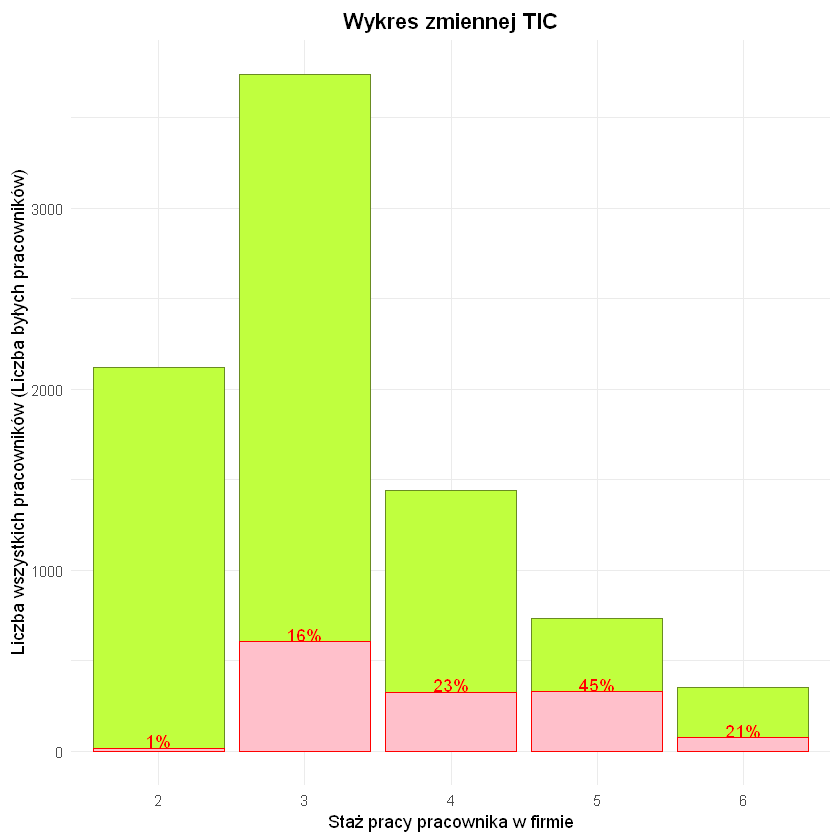

In [17]:
ggplot(data=licznosc_grup_TIC, aes(x=przedzial,wszyscy, zrezygnowali)) +
geom_bar(aes(y=wszyscy),stat="identity",color="olivedrab4",fill="olivedrab1",position = "dodge") +
geom_bar(aes(y=zrezygnowali),stat="identity",color="red",fill="pink",position = "dodge") +
labs(x = "Staż pracy pracownika w firmie", y = "Liczba wszystkich pracowników (Liczba byłych pracowników)") +
ggtitle("Wykres zmiennej TIC") +
theme_minimal() +
theme(plot.title=element_text( hjust=0.5, vjust=0.5, face='bold')) +
annotate("text", x=licznosc_grup_TIC[1,1]$przedzial, y=licznosc_grup_TIC[1,3]$zrezygnowali+40, label= paste0(licznosc_grup_TIC[1,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_TIC[2,1]$przedzial, y=licznosc_grup_TIC[2,3]$zrezygnowali+40, label= paste0(licznosc_grup_TIC[2,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_TIC[3,1]$przedzial, y=licznosc_grup_TIC[3,3]$zrezygnowali+40, label= paste0(licznosc_grup_TIC[3,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_TIC[4,1]$przedzial, y=licznosc_grup_TIC[4,3]$zrezygnowali+40, label= paste0(licznosc_grup_TIC[4,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_TIC[5,1]$przedzial, y=licznosc_grup_TIC[5,3]$zrezygnowali+40, label= paste0(licznosc_grup_TIC[5,5]$procent,"%",collapse=''), color='red') 

In [ ]:
licznosc_grup_TIC

Wykres zmiennej TIC, czyli stażu pracownika w firmie, przedstawia dość wąski zakres możliwych wartości - od 2 do 6 lat. Nie ma tutaj zatem nowozatrudnionych osób, które zrezygnowały podczas okresu próbnego. Nie ma też pracowników o bardzo długim stażu pracy, którzy prawdopodobnie staliby się tutaj obserwacjami odstającymi. Zdecydowaną przewagę liczebną w analizowanym zbiorze testowym ma grupa osób pracująca w firmie 3 lata. Następne grupy wskazują spodziewaną tendencję spadkową. Procentowe wartości osób odchodzących ma tym razem kształt odwróconej litery "U" - szczyt przypada na grupę 5 lat w firmie, gdzie z pracy zrezygnowało aż 45% osób tej grupy. 

In [18]:
licznosc_grup_Newborn=data.table(przedzial = c(0,1),wszyscy = 1:2, zrezygnowali = 1:2)
for (i in 1:2)
{
    licznosc_grup_Newborn[i,2] = dane_trn[Newborn==i-1,.N]
    licznosc_grup_Newborn[i,3] = dane_trn[Newborn==i-1 & left==1,.N]

}
licznosc_grup_Newborn[,zostali:=wszyscy-zrezygnowali]
licznosc_grup_Newborn[,procent:=round(zrezygnowali/wszyscy,2)*100]
licznosc_grup_Newborn[,przedzial:=as.factor(przedzial)]


przedzial,wszyscy,zrezygnowali,zostali,procent
0,7071,1282,5789,18
1,1318,79,1239,6


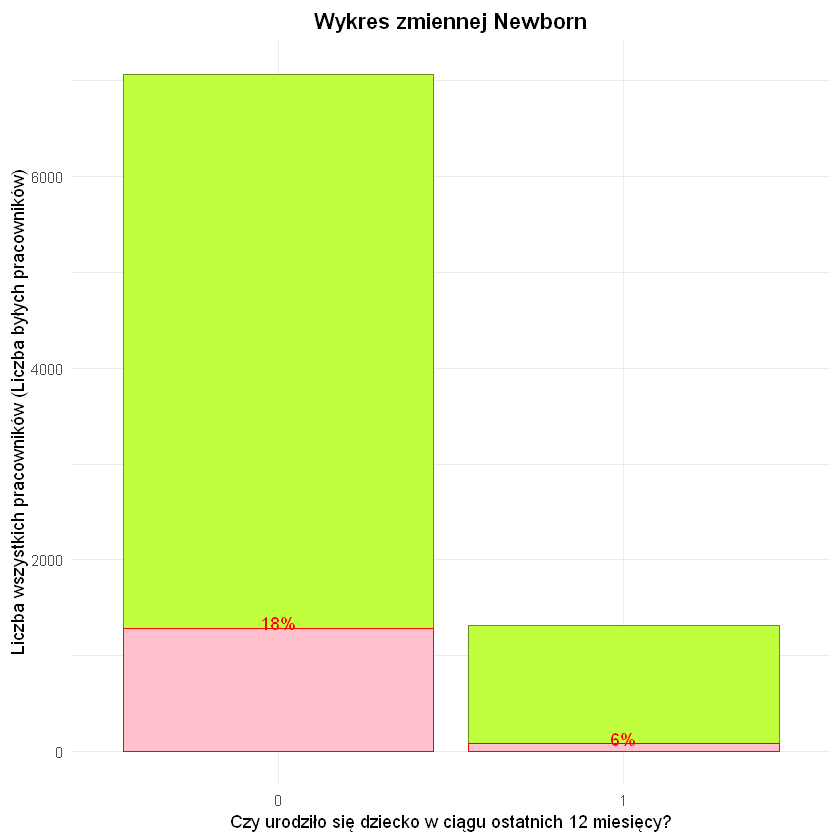

In [19]:
ggplot(data=licznosc_grup_Newborn, aes(x=przedzial,wszyscy, zrezygnowali)) +
geom_bar(aes(y=wszyscy),stat="identity",color="olivedrab4",fill="olivedrab1",position = "dodge") +
geom_bar(aes(y=zrezygnowali),stat="identity",color="red",fill="pink",position = "dodge") +
labs(x = "Czy urodziło się dziecko w ciągu ostatnich 12 miesięcy?", y = "Liczba wszystkich pracowników (Liczba byłych pracowników)") +
ggtitle("Wykres zmiennej Newborn") +
theme_minimal() +
theme(plot.title=element_text( hjust=0.5, vjust=0.5, face='bold')) +
annotate("text", x=licznosc_grup_Newborn[1,1]$przedzial, y=licznosc_grup_Newborn[1,3]$zrezygnowali+60, label= paste0(licznosc_grup_Newborn[1,5]$procent,"%",collapse=''), color='red') +
annotate("text", x=licznosc_grup_Newborn[2,1]$przedzial, y=licznosc_grup_Newborn[2,3]$zrezygnowali+60, label= paste0(licznosc_grup_Newborn[2,5]$procent,"%",collapse=''), color='red')

In [ ]:
licznosc_grup_Newborn

Ostatnia zmienna, Newborn, określa przez przypisanie wartości 1 sytuację, gdzie pracownikowi urodziło się dziecko w przeciągu ostatniego roku. W przeciwnym przypadku zmienna ma wartość 0. Wykres przedstawia dwie ważne informacje: osób z małymi dziećmi jest zdecydowanie mniej niż reszty oraz widać wyraźny spadek rezygnacji w grupie 1 w porównaniu do grupy 0. Obie informacje są mało zaskakujące. Narodziny dziecka są dość rzadkim i raczej planowanym zjawiskiem. Dodatkowy członek rodziny wymaga również większych nakładów pieniężnych, zwłaszcza na samym początku. Kobiety w ciąży oraz niedługo po porodzie często są chronione prawem zabraniającym zwolnienia. Same pracownice też raczej nie będą chciały odchodzić z pracy w trakcie ciąży lub krótko po urodzeniu, gdyż wiązałoby się to z bezsensowną utratą finansowania. W przypadku mężczyzn można się spodziewać, że niewielki odsetek odejść wiąże się z realnym ryzykiem utraty ciągłości finansowej w momencie, gdy pieniądze są najbardziej potrzebne. Można się domyślać, że pracownicy odchodzący w takim momencie z pracy to osoby o niskich zarobkach, którzy szukają lepiej płatnej pracy. Z drugiej strony mogą to być osoby, które mają tak dobrą sytuację finansową, że mogą pozwolić sobie na dłuższą przerwę w pracy i skupienie się na dziecku. 

Podsumowując, zbiór treningowy składa się z osób, które przepracowały w firmie od 2 do 6 lat. Najczęściej pracowali oni nad 3-4 projektami i zdecydowana większość za ostatni projekt otrzymała przynajmniej połowę możliwej oceny przez klienta. Większość pracowników oceniła, że ich satysfakcja z pracy wynosi powyżej 50%. Ryzyko rezygnacji z pracy rośnie, gdy pracownik nie czuje satysfakcji z pracy (poniżej 50%). Szansa odejścia rośnie też, gdy pracownik jest źle lub bardzo dobrze oceniany przez klientów. Ryzyko rezygnacji pracownika może obniżać stabilne zatrudnienie na pełen lub 1.25 etatu i praca nad 3-5 różnymi projektami w roku. Ryzyko spada również, gdy pracownikowi urodziło się niedawno dziecko. 

## Kodowanie zmiennych na WoE

Jedną z metod obróbki danych do regresji logistycznej jest zastosowanie kodowania WoE (Weight of Evidence). Przed przystąpieniem do kodowania, wszystkie zmienne zostaną poddane procesowi dyskretyzacji (binowanie zmiennych). Celem jest osiągnięcie przedziałów, które będą zawierały przynajmniej 8% wszystkich obserwacji oraz wartości WoE obliczone na tych przedziałach powinny w kolejności wykazywać charakter liniowy lub paraboliczny. Kolejnym kryterium jest zwiększanie wartości IV (Information Value). 

Poniżej przedstawiono wynik automatycznego binowania. Użyto do tego pakietu "Information". Wyniki te nie muszą spełniać podanych wyżej wymagań, ale są dobrym punktem startowym analizy. 

In [20]:
dane_trn[,left:=as.numeric(left)]

WOE_table <- create_infotables(data=dane_trn, y="left", parallel=FALSE)
WOE_table

$Tables
$Tables$S
             S   N    Percent        WOE        IV
1  [0.09,0.24] 827 0.09858148  1.3419988 0.2563843
2  [0.25,0.42] 814 0.09703183  1.5974492 0.6289737
3  [0.43,0.51] 807 0.09619740  0.6224641 0.6743268
4  [0.52,0.58] 820 0.09774705 -2.5679730 0.9469213
5  [0.59,0.65] 853 0.10168077 -2.5267701 1.2247905
6  [0.66,0.72] 831 0.09905829 -1.8735874 1.4068888
7  [0.73,0.78] 841 0.10025033 -0.2627502 1.4132123
8  [0.79,0.85] 904 0.10776016 -0.1604398 1.4158382
9  [0.86,0.92] 848 0.10108475 -0.2513752 1.4216974
10    [0.93,1] 844 0.10060794  0.0000000 1.4216974

$Tables$LPE
           LPE   N    Percent        WOE         IV
1  [0.36,0.49] 825 0.09834307  0.7211454 0.06397803
2   [0.5,0.53] 712 0.08487305  0.6093928 0.10218561
3  [0.54,0.58] 877 0.10454166  0.2948298 0.11219744
4  [0.59,0.64] 847 0.10096555 -2.4442939 0.37676620
5  [0.65,0.71] 923 0.11002503 -2.5316053 0.67816199
6  [0.72,0.77] 838 0.09989272 -1.5846654 0.82263910
7  [0.78,0.83] 825 0.09834307 -0.1000666 0.8

In [21]:
cor(dane_trn[,.(S,LPE,ANH)])

,S,LPE,ANH
S,1.00000000,0.1014741,-0.01339983
LPE,0.10147409,1.0000000,0.25251012
ANH,-0.01339983,0.2525101,1.00000000


In [22]:
dane_trn[S<=0.42,S:=0.42]
dane_trn[S>0.42 & S<=0.51,S:=0.51]
dane_trn[S>0.51 & S<=0.72,S:=0.72]
dane_trn[S>0.72 ,S:=1]
WOE_table <- create_infotables(data=dane_trn[,.(S,left)], y="left", parallel=FALSE)
WOE_table

$Tables
$Tables$S
            S    N   Percent        WOE        IV
1 [0.42,0.42] 1641 0.1956133  1.4694112 0.6234518
2 [0.51,0.51]  807 0.0961974  0.6224641 0.6688048
3 [0.72,0.72] 2504 0.2984861 -2.2723793 1.3807733
4       [1,1] 3437 0.4097032 -0.5417178 1.4803590


$Summary
  Variable       IV
1        S 1.480359

attr(,"class")
[1] "Information"

In [23]:
dane_trn[LPE<=0.53,LPE:=0.53]
dane_trn[LPE>0.53 & LPE<=0.58,LPE:=0.58]
dane_trn[LPE>0.58 & LPE<=0.77,LPE:=0.77]
dane_trn[LPE>0.77 & LPE<=0.83,LPE:=0.83]
dane_trn[LPE>0.83 ,LPE:=1]
WOE_table <- create_infotables(data=dane_trn[,.(LPE,left)], y="left", parallel=FALSE)
WOE_table

$Tables
$Tables$LPE
          LPE    N    Percent        WOE        IV
1 [0.53,0.53] 1537 0.18321612  0.6700781 0.1014599
2 [0.58,0.58]  877 0.10454166  0.2948298 0.1114717
3 [0.77,0.77] 2608 0.31088330 -2.1070370 0.7824884
4 [0.83,0.83]  825 0.09834307 -0.1000666 0.7834401
5       [1,1] 2542 0.30301585  0.4117877 0.8421623


$Summary
  Variable        IV
1      LPE 0.8421623

attr(,"class")
[1] "Information"

In [24]:
WOE_table <- create_infotables(data=dane_trn[,.(NP,left)], y="left", parallel=FALSE)
WOE_table
#bez zmian

$Tables
$Tables$NP
     NP    N   Percent        WOE        IV
1 [2,2] 1102 0.1313625  1.7980803 0.6547916
2 [3,3] 2495 0.2974133 -2.8368712 1.5922396
3 [4,4] 2572 0.3065920 -1.0915263 1.8414013
4 [5,7] 2220 0.2646323  0.6069216 1.9594834


$Summary
  Variable       IV
1       NP 1.959483

attr(,"class")
[1] "Information"

In [25]:
dane_trn[ANH<=150,ANH:=150]
dane_trn[ANH>150 & ANH<=164,ANH:=164]
dane_trn[ANH>164 & ANH<=217,ANH:=217]
dane_trn[ANH>217 & ANH<=235,ANH:=235]
dane_trn[ANH>235 & ANH<=264,ANH:=264]
dane_trn[ANH>264 ,ANH:=310]
WOE_table <- create_infotables(data=dane_trn[,.(ANH,left)], y="left", parallel=FALSE)
WOE_table

$Tables
$Tables$ANH
        ANH    N   Percent        WOE         IV
1 [150,150] 1621 0.1932292  0.5748966 0.07664724
2 [164,164]  865 0.1031112  0.3807258 0.09356513
3 [217,217] 2509 0.2990821 -2.6165610 0.94735974
4 [235,235]  868 0.1034688 -0.5152344 0.97032487
5 [264,264] 1652 0.1969245  0.2155666 0.98015334
6 [310,310]  874 0.1041841  1.0432005 1.13404968


$Summary
  Variable      IV
1      ANH 1.13405

attr(,"class")
[1] "Information"

In [26]:
WOE_table <- create_infotables(data=dane_trn[,.(TIC,left)], y="left", parallel=FALSE)
WOE_table#bez zmian

$Tables
$Tables$TIC
    TIC    N   Percent          WOE        IV
1 [2,2] 2122 0.2529503 -3.064998750 0.8743562
2 [3,3] 3739 0.4457027  0.002749607 0.8743596
3 [4,4] 1440 0.1716534  0.420780580 0.9091897
4 [5,6] 1088 0.1296936  1.123005948 1.1352168


$Summary
  Variable       IV
1      TIC 1.135217

attr(,"class")
[1] "Information"

In [27]:
WOE_table <- create_infotables(data=dane_trn[,.(Newborn,left)], y="left", parallel=FALSE)
WOE_table#bez zmian

$Tables
$Tables$Newborn
  Newborn    N   Percent        WOE         IV
1       0 7071 0.8428895  0.1341442 0.01586246
2       1 1318 0.1571105 -1.1109296 0.14722907


$Summary
  Variable        IV
1  Newborn 0.1472291

attr(,"class")
[1] "Information"

Poniżej przedstawiono podsumowanie wprowadzonej dyskretyzacji - górne granice przedziałów, ich wartości WoE oraz skumulowane IV. 

In [28]:
WOE_table <- create_infotables(data=dane_trn[,.(left,S, LPE, NP, ANH, TIC, Newborn)], y="left", parallel=FALSE)
WOE_table

$Tables
$Tables$S
            S    N   Percent        WOE        IV
1 [0.42,0.42] 1641 0.1956133  1.4694112 0.6234518
2 [0.51,0.51]  807 0.0961974  0.6224641 0.6688048
3 [0.72,0.72] 2504 0.2984861 -2.2723793 1.3807733
4       [1,1] 3437 0.4097032 -0.5417178 1.4803590

$Tables$LPE
          LPE    N    Percent        WOE        IV
1 [0.53,0.53] 1537 0.18321612  0.6700781 0.1014599
2 [0.58,0.58]  877 0.10454166  0.2948298 0.1114717
3 [0.77,0.77] 2608 0.31088330 -2.1070370 0.7824884
4 [0.83,0.83]  825 0.09834307 -0.1000666 0.7834401
5       [1,1] 2542 0.30301585  0.4117877 0.8421623

$Tables$NP
     NP    N   Percent        WOE        IV
1 [2,2] 1102 0.1313625  1.7980803 0.6547916
2 [3,3] 2495 0.2974133 -2.8368712 1.5922396
3 [4,4] 2572 0.3065920 -1.0915263 1.8414013
4 [5,7] 2220 0.2646323  0.6069216 1.9594834

$Tables$ANH
        ANH    N   Percent        WOE         IV
1 [150,150] 1621 0.1932292  0.5748966 0.07664724
2 [164,164]  865 0.1031112  0.3807258 0.09356513
3 [217,217] 2509 0.29

Wydruk powyżej przedstawia następujące zależności wartości WoE: 

1) Zgodnie z przewidywaniami, zmienne S, LPE, NP i ANH mają charakter paraboliczny (układają się w literę "U" wraz ze wzrostem wartości zmiennej). 
2) Zmienna TIC straciła kształt odwróconej litery "U" na rzecz trendu (liniowego) rosnącego. 

Należy tutaj zauważyć, że wartości IV dla wszystkich zmiennych poza Newborn są ogromne - "reguła kciuka" nakazuje, by wszystkie zmienne z IV powyżej 0.5 poddać dodatkowym rozważaniom pod kątem potencjalnego korzystania z informacji, którą chce się przewidzieć. Na podstawie dostępnych informacji nie widać przesłanek, by którakolwiek ze zmiennych powinna być wyrzucona. 

Poziom Satysfakcji S jest daną ankietową, którą wypełniają tylko osoby aktywnie pracujące w firmie (nawet jeśli są w trakcie poszukiwania innej pracy). 
Ocena ostatniego wykonanego projektu LPE bierze pod uwagę ostatni skończony projekt. Problem mógłby nastąpić, gdyby zmienna zwracała ocenę projektu niedokończonego przez danego pracownika. Najniższa ocena wynosi 0.4, więc można się spodziewać, że żaden projekt zawarty w danych nie upadł. 
Staż pracownika w firmie TIC mógłby być problemem, gdyby pewna liczba lat oznaczała zwolnienie. 
Liczba projektów NP byłaby podejrzana, gdyby pojawiły się wartości równe 0 wraz ze zmienną left równą 1. 
Zmienna średniego miesięcznego czasu pracy ANH również nie wykazuje nic podejrzanego. 
Ponadto żadna ze zmiennych nie jest wprost pochodną zmiennej left. 

Poniżej zmienne kodowane są na WoE.

In [29]:

dane_trn[S<=0.42,S_WOE:=1.4694112]
dane_trn[S>0.42 & S<=0.51,S_WOE:=0.6224641]
dane_trn[S>0.51 & S<=0.72,S_WOE:=-2.2723793]
dane_trn[S>0.72 ,S_WOE:=-0.5417178]

dane_tst[S<=0.42,S_WOE:=1.4694112]
dane_tst[S>0.42 & S<=0.51,S_WOE:=0.6224641]
dane_tst[S>0.51 & S<=0.72,S_WOE:=-2.2723793]
dane_tst[S>0.72 ,S_WOE:=-0.5417178]

In [30]:
dane_trn[LPE<=0.53,LPE_WOE:=0.6700781 ]
dane_trn[LPE>0.53 & LPE<=0.58,LPE_WOE:=0.2948298 ]
dane_trn[LPE>0.58 & LPE<=0.77,LPE_WOE:=-2.1070370 ]
dane_trn[LPE>0.77 & LPE<=0.83,LPE_WOE:=-0.1000666 ]
dane_trn[LPE>0.83 ,LPE_WOE:=0.4117877 ]

dane_tst[LPE<=0.53,LPE_WOE:=0.6700781 ]
dane_tst[LPE>0.53 & LPE<=0.58,LPE_WOE:=0.2948298 ]
dane_tst[LPE>0.58 & LPE<=0.77,LPE_WOE:=-2.1070370 ]
dane_tst[LPE>0.77 & LPE<=0.83,LPE_WOE:=-0.1000666 ]
dane_tst[LPE>0.83 ,LPE_WOE:=0.4117877 ]

In [31]:
dane_trn[NP<=2 , NP_WOE:=1.7980803  ]
dane_trn[NP==3 , NP_WOE:=-2.8368712  ]
dane_trn[NP==4 , NP_WOE:=-1.0915263  ]
dane_trn[NP>4  , NP_WOE:=0.6069216  ]

dane_tst[NP<=2, NP_WOE:=1.7980803  ]
dane_tst[NP==3, NP_WOE:=-2.8368712  ]
dane_tst[NP==4, NP_WOE:=-1.0915263  ]
dane_tst[NP>4 , NP_WOE:=0.6069216  ]

In [32]:
dane_trn[ANH<=150,ANH_WOE:=0.5748966 ]
dane_trn[ANH>150 & ANH<=164,ANH_WOE:=0.3807258 ]
dane_trn[ANH>164 & ANH<=217,ANH_WOE:=-2.6165610 ]
dane_trn[ANH>217 & ANH<=235,ANH_WOE:=-0.5152344 ]
dane_trn[ANH>235 & ANH<=264,ANH_WOE:=0.2155666 ]
dane_trn[ANH>264 ,ANH_WOE:=1.0432005 ]

dane_tst[ANH<=150,ANH_WOE:=0.5748966 ]
dane_tst[ANH>150 & ANH<=164,ANH_WOE:=0.3807258 ]
dane_tst[ANH>164 & ANH<=217,ANH_WOE:=-2.6165610 ]
dane_tst[ANH>217 & ANH<=235,ANH_WOE:=-0.5152344 ]
dane_tst[ANH>235 & ANH<=264,ANH_WOE:=0.2155666 ]
dane_tst[ANH>264 ,ANH_WOE:=1.0432005 ]

In [33]:
dane_trn[TIC<=2 , TIC_WOE:=-3.064998750   ]
dane_trn[TIC==3 , TIC_WOE:=0.002749607   ]
dane_trn[TIC==4 , TIC_WOE:=0.420780580  ]
dane_trn[TIC>4  , TIC_WOE:=1.123005948  ]

dane_tst[TIC<=2, TIC_WOE:=-3.064998750  ]
dane_tst[TIC==3, TIC_WOE:=0.002749607  ]
dane_tst[TIC==4, TIC_WOE:=0.420780580  ]
dane_tst[TIC>4 , TIC_WOE:=1.123005948  ]

In [34]:
dane_trn[Newborn==0 , Newborn_WOE:= 0.1341442   ]
dane_trn[Newborn==1 , Newborn_WOE:=-1.1109296   ]
dane_tst[Newborn==0 , Newborn_WOE:= 0.1341442  ]
dane_tst[Newborn==1 , Newborn_WOE:=-1.1109296  ]

## Modelowanie rezygnacji z pracy przy użyciu regresji logistycznej

In [35]:
Zmienne_WOE=c('S_WOE', 'LPE_WOE',
                'NP_WOE', 'ANH_WOE', 'TIC_WOE', 'Newborn_WOE')

In [36]:
(formula1<-as.formula(paste('left ~ ',paste(Zmienne_WOE,collapse = '+'))))
model1 <- glm(formula1, data = dane_trn, family = binomial(link = 'logit'))
summary(model1)


left ~ S_WOE + LPE_WOE + NP_WOE + ANH_WOE + TIC_WOE + Newborn_WOE


Call:
glm(formula = formula1, family = binomial(link = "logit"), data = dane_trn)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5749  -0.2677  -0.0807  -0.0151   4.5546  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.78981    0.06123 -29.231   <2e-16 ***
S_WOE        0.60091    0.03585  16.763   <2e-16 ***
LPE_WOE      0.83583    0.05623  14.864   <2e-16 ***
NP_WOE       0.77430    0.03586  21.592   <2e-16 ***
ANH_WOE      0.80593    0.04911  16.412   <2e-16 ***
TIC_WOE      1.10965    0.07424  14.948   <2e-16 ***
Newborn_WOE  1.08521    0.12140   8.939   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7438.7  on 8388  degrees of freedom
Residual deviance: 3501.2  on 8382  degrees of freedom
AIC: 3515.2

Number of Fisher Scoring iterations: 8


Strategią budowania modelu było najpierw utworzenie modelu ze wszystkimi zmiennymi WoE. Następnym krokiem była próba usunięcia jednej zmiennej i porównanie wyników Gini Index oraz kryterium AIC Akaike. Okazało się, że próba usunięcia którejkolwiek ze zmiennych skutkowała w pogorszeniu się predykcji - Gini Index zawsze lekko spadało, a wartość AIC rosła. Drugim podejściem było dodatkowe zastosowanie funkcji step po odjęciu jednej zmiennej, co również nie dało lepszych wyników. Należy tutaj nadmienić, że w każdej sprawdzanej sytuacji wszystkie obliczone współczynniki były niezerowe na przyjętym poziomie istotności 0.05. Niska liczba iteracji nie daje podstaw by podejrzewać, że założenia regresji zostały złamane. 

In [37]:
rocplot=function(pred,truth,...)
    {
    predob=prediction(pred,truth)
    perf=performance(predob,'tpr','fpr')
    gini=2*attributes(performance(predob,"auc"))$y.values[[1]]-1
    plot(perf,main=paste0("Gini index: ",round(gini,2)))
    invisible()
}

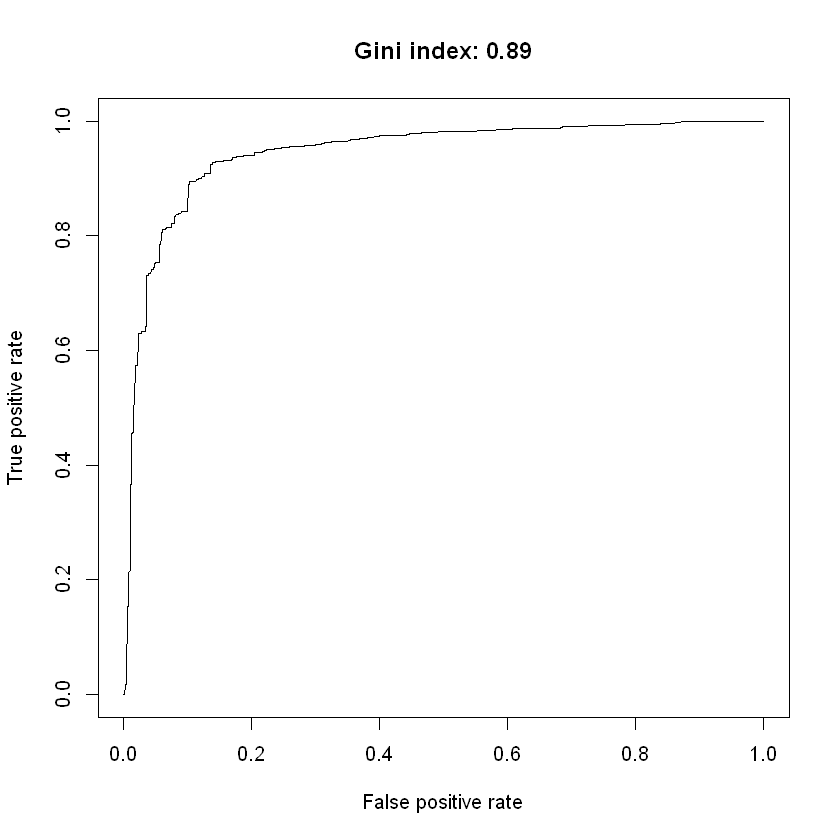

In [38]:
wyniki1_ver0=rocplot(predict(model1,dane_trn,type='response'),dane_trn$left)

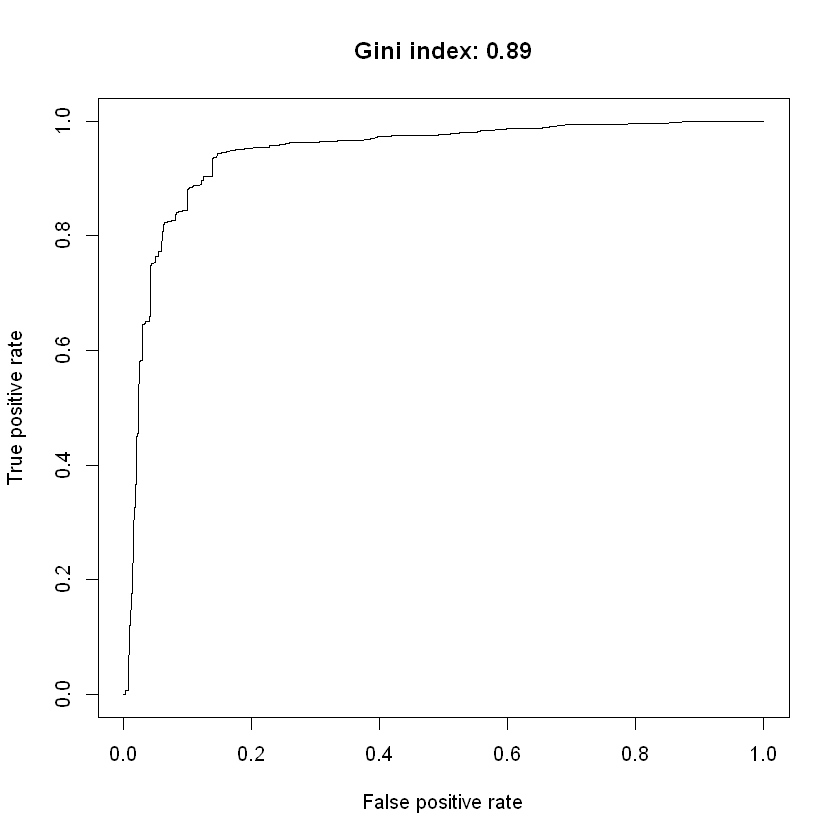

In [39]:
wyniki1_ver1=rocplot(predict(model1,dane_tst,type='response'),dane_tst$left)

Powyżej przedstawiono dwa wykresy krzywej ROC i wartości współczynnika Gini. Górny wykres to sprawdzenie dopasowania do zbioru treningowego, a dolny do testowego. Wartości współczynnika są takie same oraz wykresy mają zbliżone do siebie kształty. Same krzywe nie mają żadnych większych "garbów", które mogłyby wzbudzać podejrzenia. 

Z uwagi na to, że dane są niezbalansowane, często dobrym pomysłem jest dobranie wartości cutoffu tak, by lepiej wyłapywane były przypadki rzadsze, w tym przypadku są to osoby rezygnujące z pracy. Poniżej przedstawiono macierz konfuzji dla wartości cutoff równej 0.5. 

In [40]:
scores <- predict.glm(model1,newdata=dane_tst,type="response")
wynik <- data.frame(actuals=dane_tst$left)
cut_off <- 0.50
forecast <- data.table(forecast=scores>cut_off)*1
(macierz_konf=table(wynik$actuals, forecast[,forecast]))

   
       0    1
  0 2827  145
  1  154  485

In [41]:
accuracy=(sum(diag(macierz_konf)))/sum(macierz_konf)
specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])

cat("Accuracy równa się: ", accuracy,'\n')
cat("Specificity równa się: ", specificity,'\n')
cat("Sensitivity równa się: ", sensitivity)

Accuracy równa się:  0.9171975 
Specificity równa się:  0.9512113 
Sensitivity równa się:  0.7589984

Wysoka wartość accuracy nie jest zaskoczeniem, model trywialny, który bierze zawsze klasę liczniejszą, będzie miał accuracy na poziomie 83%.
Wartość sensitivity wydaje się być zdecydowanie za mała w porównaniu do specificity. Poprzez manipulowanie wartością cutoff można próbować zmniejszyć dysproporcje tak, by zyskać dużo na sensitivity i jednocześnie nie stracić wiele na specificity. Do wyznaczenia tej wartości zostanie użyta statystyka Youdena, która będzie maksymalizowana. Statystyka ta jest definiowana jako Specificity+Sensitivity-1.

In [42]:
cutoffy=data.frame(cutoff=seq(0.2,0.8,0.01),Youden_stat=rep(0,length(seq(0.2,0.8,0.01))))
licznik=1
for (i in seq(0.2,0.8,0.01))
    {
        cut_off = i
        forecast <- data.table(forecast=scores>cut_off)*1
        macierz_konf=table(wynik$actuals, forecast[,forecast])
        specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
        sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])
        cutoffy[licznik,1]=i
        cutoffy[licznik,2]=specificity+sensitivity-1
        licznik=licznik+1
    
    }

In [43]:
cutoffy[which.max(cutoffy$Youden_stat),1]

[1] 0.25

Z obliczeń wynika, że optymalnym rozwiązaniem będzie cutoff równy 0.25.

In [44]:
scores <- predict.glm(model1,newdata=dane_tst,type="response")
wynik <- data.frame(actuals=dane_tst$left)
cut_off <- 0.25
forecast <- data.table(forecast=scores>cut_off)*1
(macierz_konf=table(wynik$actuals, forecast[,forecast]))

   
       0    1
  0 2669  303
  1   74  565

In [45]:
accuracy=(sum(diag(macierz_konf)))/sum(macierz_konf)
specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])
cat("Accuracy równa się: ", accuracy,'\n')
cat("Specificity równa się: ", specificity,'\n')
cat("Sensitivity równa się: ", sensitivity)

Accuracy równa się:  0.8955968 
Specificity równa się:  0.8980485 
Sensitivity równa się:  0.8841941

Zamiana wartości cutoff z 0.5 na 0.25 skutkuje spadkiem specificity, lekkim spadkiem accuracy i wyraźnym wzrostem sensitivity. 
Przedstawiona tutaj metoda może zawsze być zastąpiona inną, niekoniecznie opierającą się tylko na danych (np. biorącą pod uwagę koszt pojedynczej interwencji wobec wskazanego pracownika). 
Poniżej przedstawiono macierz konfuzji obliczoną na danych treningowych. 

In [75]:
#trening
scores <- predict.glm(model1,newdata=dane_trn,type="response")
wynik <- data.frame(actuals=dane_trn$left)
cut_off <- 0.25
forecast <- data.table(forecast=scores>cut_off)*1
(macierz_konf=table(wynik$actuals, forecast[,forecast]))
accuracy=(sum(diag(macierz_konf)))/sum(macierz_konf)
specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])
cat("Accuracy treningowe równa się: ", accuracy,'\n')
cat("Specificity treningowe równa się: ", specificity,'\n')
cat("Sensitivity treningowe równa się: ", sensitivity)

   
       0    1
  0 6308  720
  1  143 1218

Accuracy treningowe równa się:  0.8971272 
Specificity treningowe równa się:  0.8975526 
Sensitivity treningowe równa się:  0.8949302

Dla wybranego cutoffu wyniki są bardzo zbliżone, z lekką przewagą zbioru treningowego. Wygląda na to, że model nie jest przeuczony.

## Podsumowanie

Otrzymane powyżej wyniki Gini Index oraz statystyki powstałe na podstawie macierzy konfuzji są zadowalające. Można zatem uznać, że zbudowany model regresji logistycznej jest dobrym rozwiązaniem postawionego problemu typowania pracowników chcących odejść z firmy. Metoda ta jest bardzo łatwa w użyciu i znając wartości współczynników regresji można ją stosować bez specjalistycznych narzędzi. Należy jednak pamiętać, że użycie jej wymaga dostępu do informacji pracownika o wszystkich 6 zmiennych użytych w modelu. Potencjalnie da się uzyskać jeszcze lepsze wyniki za pomocą innych, bardziej skomplikowanych metod statystycznych, które lepiej radzą sobie z brakiem liniowości.

## Dodatek: Regresja logistyczna na danych surowych

Jako ciekawostkę można sprawdzić, jak poradziłby sobie model bez pracy analityka. Skonstruowany zostanie model, gdzie dane nie były poddane żadnej obróbce (np. dyskretyzacja) poza dokonanym już podziałem na zbiory treningowy i testowy. Wszystkie zmienne poza Newborn potraktowane będą jako ciągłe. Zastosowana zostanie automatyczna metoda krokowa zaczynająca od modelu ze wszystkimi zmiennymi.

In [49]:
Zmienne=c('S', 'LPE',
                'NP', 'ANH', 'TIC', 'Newborn')

In [76]:
(formula2<-as.formula(paste('left ~ ',paste(Zmienne,collapse = '+'))))
model2 <- glm(formula2, data = dane_trn2, family = binomial(link = 'logit'))
summary(model2)
model2 <- step(model2,direction = "both")
summary(model2)

left ~ S + LPE + NP + ANH + TIC + Newborn


Call:
glm(formula = formula2, family = binomial(link = "logit"), data = dane_trn2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1591  -0.5384  -0.3500  -0.2015   3.0731  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.2819841  0.1943081  -6.598 4.18e-11 ***
S           -3.8316962  0.1467196 -26.116  < 2e-16 ***
LPE          0.5617407  0.2177813   2.579   0.0099 ** 
NP          -0.3828112  0.0323455 -11.835  < 2e-16 ***
ANH          0.0039186  0.0007495   5.228 1.71e-07 ***
TIC          0.6290437  0.0327739  19.193  < 2e-16 ***
Newborn1    -1.3450332  0.1306470 -10.295  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7438.7  on 8388  degrees of freedom
Residual deviance: 5863.4  on 8382  degrees of freedom
AIC: 5877.4

Number of Fisher Scoring iterations: 6


Start:  AIC=5877.39
left ~ S + LPE + NP + ANH + TIC + Newborn

          Df Deviance    AIC
<none>         5863.4 5877.4
- LPE      1   5870.1 5882.1
- ANH      1   5891.0 5903.0
- Newborn  1   6001.0 6013.0
- NP       1   6012.0 6024.0
- TIC      1   6243.9 6255.9
- S        1   6661.2 6673.2



Call:
glm(formula = left ~ S + LPE + NP + ANH + TIC + Newborn, family = binomial(link = "logit"), 
    data = dane_trn2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1591  -0.5384  -0.3500  -0.2015   3.0731  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.2819841  0.1943081  -6.598 4.18e-11 ***
S           -3.8316962  0.1467196 -26.116  < 2e-16 ***
LPE          0.5617407  0.2177813   2.579   0.0099 ** 
NP          -0.3828112  0.0323455 -11.835  < 2e-16 ***
ANH          0.0039186  0.0007495   5.228 1.71e-07 ***
TIC          0.6290437  0.0327739  19.193  < 2e-16 ***
Newborn1    -1.3450332  0.1306470 -10.295  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7438.7  on 8388  degrees of freedom
Residual deviance: 5863.4  on 8382  degrees of freedom
AIC: 5877.4

Number of Fisher Scoring iterations: 6


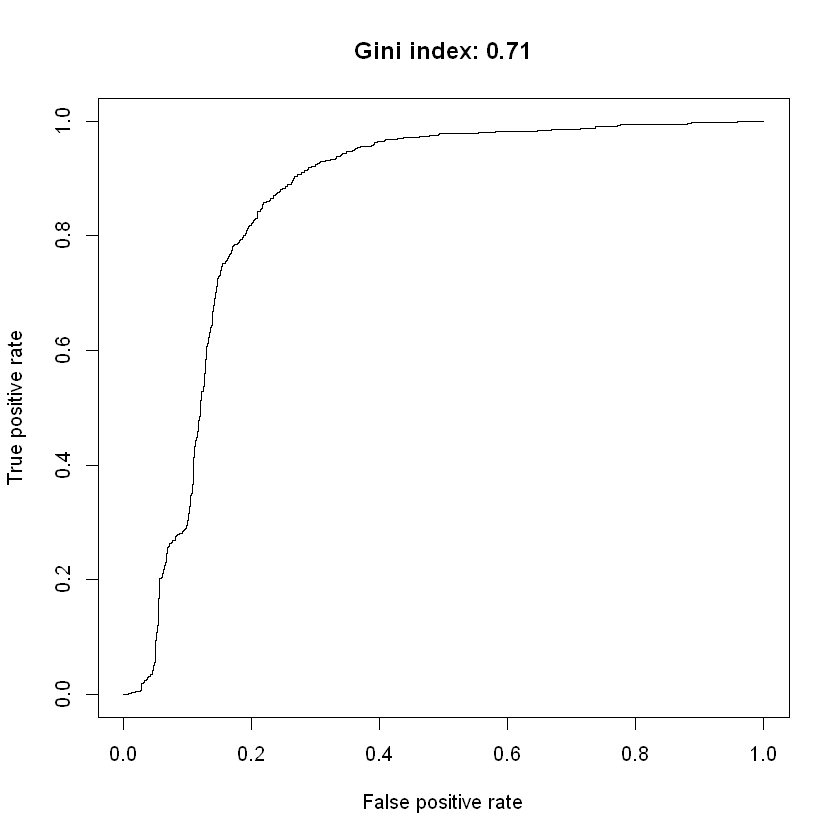

In [77]:
wyniki2_ver1=rocplot(predict(model2,dane_tst2,type='response'),dane_tst2$left)

In [81]:
scores <- predict.glm(model2,newdata=dane_tst2,type="response")
wynik <- data.frame(actuals=dane_tst2$left)
cut_off <- 0.50
forecast <- data.table(forecast=scores>cut_off)*1
(macierz_konf=table(wynik$actuals, forecast[,forecast]))
accuracy=(sum(diag(macierz_konf)))/sum(macierz_konf)
specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])
cat("Accuracy (cutoff 0.5) równa się: ", accuracy,'\n')
cat("Specificity (cutoff 0.5) równa się: ", specificity,'\n')
cat("Sensitivity (cutoff 0.5) równa się: ", sensitivity)

   
       0    1
  0 2807  165
  1  519  120

Accuracy treningowe równa się:  0.8105788 
Specificity treningowe równa się:  0.9444818 
Sensitivity treningowe równa się:  0.1877934

In [80]:
scores <- predict.glm(model2,newdata=dane_tst2,type="response")
wynik <- data.frame(actuals=dane_tst2$left)
cut_off <- 0.25
forecast <- data.table(forecast=scores>cut_off)*1
(macierz_konf=table(wynik$actuals, forecast[,forecast]))
accuracy=(sum(diag(macierz_konf)))/sum(macierz_konf)
specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])
cat("Accuracy (cutoff 0.25) równa się: ", accuracy,'\n')
cat("Specificity (cutoff 0.25) równa się: ", specificity,'\n')
cat("Sensitivity (cutoff 0.25) równa się: ", sensitivity)

   
       0    1
  0 2528  444
  1  172  467

Accuracy treningowe równa się:  0.8294101 
Specificity treningowe równa się:  0.8506057 
Sensitivity treningowe równa się:  0.7308294

In [54]:
cutoffy=data.frame(cutoff=seq(0.1,0.8,0.01),Youden_stat=rep(0,length(seq(0.1,0.8,0.01))))
licznik=1
for (i in seq(0.1,0.8,0.01))
    {
        cut_off = i
        forecast <- data.table(forecast=scores>cut_off)*1
        macierz_konf=table(wynik$actuals, forecast[,forecast])
        specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
        sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])
        cutoffy[licznik,1]=i
        cutoffy[licznik,2]=specificity+sensitivity-1
        licznik=licznik+1
    
    }

In [55]:
cutoffy[which.max(cutoffy$Youden_stat),1]

[1] 0.16

In [82]:
scores <- predict.glm(model2,newdata=dane_tst2,type="response")
wynik <- data.frame(actuals=dane_tst2$left)
cut_off <- 0.16
forecast <- data.table(forecast=scores>cut_off)*1
(macierz_konf=table(wynik$actuals, forecast[,forecast]))
accuracy=(sum(diag(macierz_konf)))/sum(macierz_konf)
specificity=macierz_konf[1]/(macierz_konf[1]+macierz_konf[3])
sensitivity=macierz_konf[4]/(macierz_konf[2]+macierz_konf[4])
cat("Accuracy (cutoff 0.16) równa się: ", accuracy,'\n')
cat("Specificity (cutoff 0.16) równa się: ", specificity,'\n')
cat("Sensitivity (cutoff 0.16) równa się: ", sensitivity)

   
       0    1
  0 2247  725
  1   78  561

Accuracy (cutoff 0.25) równa się:  0.7776239 
Specificity (cutoff 0.25) równa się:  0.7560565 
Sensitivity (cutoff 0.25) równa się:  0.8779343

Z powyższych wyników widać, że jest model z WoE osiągnął dużo lepsze wyniki. Model "na szybko" ma te same zmienne i również nie wygląda, by założenia były złamane. Jest jednak wyraźna różnica w wartości Gini Index. Sam wykres krzywej ROC posiada w okolicach 0.1 "garb", który może martwić. Samo accuracy jest na granicy 82%, czyli  jest blisko accuracy modelu trywialnego. 